# Results Analysis 

This notebook analyzes results produced by the _anti-entropy reinforcement learning_ experiments. The practical purpose of this notebook is to create graphs that can be used to display anti-entropy topologies, but also to extract information relevant to each experimental run. 

In [1]:
%matplotlib notebook

import os 
import re 
import glob 
import json
import unicodedata

import numpy as np 
import pandas as pd 
import seaborn as sns
import networkx as nx
import matplotlib as mpl 
import graph_tool.all as gt
import matplotlib.pyplot as plt 

from nx2gt import nx2gt
from datetime import timedelta 
from collections import defaultdict

/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:1480: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


## Data Loading 

The data directory contains directories whose names are the hosts along with configuration files for each run. Each run is stored in its own `metrics.json` file, suffixed by the run number. The data loader yields _all_ rows from _all_ metric files and appends them with the correct configuration data. 

In [2]:
DATA = "../data"
HOSTS = "hosts.json"
RESULTS = "metrics-*.json"
CONFIGS = "config-*.json"
NULLDATE = "0001-01-01T00:00:00Z"
DURATION = re.compile("^([\d\.]+)(\w+)$") 

def suffix(path):
    # Get the run id from the path 
    name, _ = os.path.splitext(path)
    return int(name.split("-")[-1]) 


def parse_duration(d):
    match = DURATION.match(d)
    if match is None:
        raise TypeError("could not parse duration '{}'".format(d))
    amount, units = match.groups() 
    amount = float(amount)

    unitkw = {
        "µs": "microseconds", 
        "ms": "milliseconds", 
        "s": "seconds", 
    }[units]
    
    return timedelta(**{unitkw:amount}).total_seconds()


def load_hosts(path=DATA):
    with open(os.path.join(path, HOSTS), 'r') as f:
        return json.load(f)


def load_configs(path=DATA):
    configs = {}
    for name in glob.glob(os.path.join(path, CONFIGS)):
        with open(name, 'r') as f:
            configs[suffix(name)] = json.load(f)
    return configs 


def slugify(name):
    slug = unicodedata.normalize('NFKD', name)
    slug = str(slug.encode('ascii', 'ignore')).lower()
    slug = re.sub(r'[^a-z0-9]+', '-', slug).strip('-')
    slug = re.sub(r'[-]+', '-', slug)
    return slug 


def load_results(path=DATA):
    hosts = load_hosts(path)
    configs = load_configs(path) 
    for host in os.listdir(path):
        for name in glob.glob(os.path.join(path, host, "metrics-*.json")):
            run = suffix(name) 
            with open(name, 'r') as f:
                for line in f:
                    row = json.loads(line.strip())
                    row['name'] = host 
                    row['host'] = hosts[host]["hostname"] + ":3264"
                    row['runid'] = run 
                    row['config'] = configs[run]
                    yield row


def merge_results(path, data=DATA):
    # Merge all of the results into a single unified file 
    with open(path, 'w') as f:
        for row in load_results(data):
            f.write(json.dumps(row))
            f.write("\n")

## Graph Extraction 

This section extracts a NeworkX graph for each of the experimental runs such that each graph defines an anti-entropy topology.

In [3]:
def extract_graphs(path=DATA, outdir=None):
    graphs = defaultdict(nx.DiGraph)
    for row in load_results(path):
        
        # Get the graph for the topology 
        G = graphs[row["runid"]]
        
        # Update the graph information 
        name = row["bandit"]["strategy"].title()
        epsilon =  row["config"]["replicas"].get("epsilon", None)
        if epsilon:
            name += " ε={}".format(epsilon)
        
        G.graph.update({
            "name": name + " (E{})".format(row["runid"]), 
            "experiment": row["runid"], 
            "uptime": row["config"]["replicas"]["uptime"], 
            "bandit": row["config"]["replicas"]["bandit"], 
            "epsilon": epsilon or "", 
            "anti_entropy_interval": row["config"]["replicas"]["delay"], 
            "workload_duration": row["config"]["clients"]["config"]["duration"], 
            "n_clients": len(row["config"]["clients"]["hosts"]),
#             "workload": row["config"]["clients"]["hosts"], 
            "store": row["store"], 
        })
        
        # Update the vertex information
        vnames = row["name"].split("-")
        vertex = {
            "duration": row["duration"], 
            "finished": row["finished"] if row["finished"] != NULLDATE else "", 
            "started": row["started"] if row["started"] != NULLDATE else "",
            "keys_stored": row["nkeys"], 
            "reads": row["reads"], 
            "writes": row["writes"], 
            "throughput": row["throughput"], 
            "location": " ".join(vnames[1:-1]).title(), 
            "pid": int(vnames[-1]), 
            "name": row["name"]
        }
        source_id = row["host"]
        source = G.add_node(source_id, **vertex)
        
        # Get bandit edge information 
        bandit_counts = dict(zip(row["peers"], row["bandit"]["counts"]))
        bandit_values = dict(zip(row["peers"], row["bandit"]["values"]))
        
        # Add the edges from the sync table 
        for target_id, stats in row["syncs"].items():
            edge = {
                "count": bandit_counts[target_id], 
                "reward": bandit_values[target_id], 
                "misses": stats["Misses"],
                "pulls": stats["Pulls"], 
                "pushes": stats["Pushes"], 
                "syncs": stats["Syncs"],
                "versions": stats["Versions"], 
                "mean_pull_latency": parse_duration(stats["PullLatency"]["mean"]),
                "mean_push_latency": parse_duration(stats["PushLatency"]["mean"]),
            }
            G.add_edge(source_id, target_id, **edge)
    
    # Write Graphs
    if outdir:
        for G in graphs.values():
            opath = os.path.join(outdir, slugify(G.name)+".graphml.gz")
            nx.write_graphml(G, opath)
    
    return graphs 

        
# for G in extract_graphs(outdir="../graphs").values():
for G in extract_graphs().values():
    print(nx.info(G))
    print()

Name: Uniform Selection (E1)
Type: DiGraph
Number of nodes: 24
Number of edges: 552
Average in degree:  23.0000
Average out degree:  23.0000

Name: Epsilon Greedy ε=0.5 (E4)
Type: DiGraph
Number of nodes: 24
Number of edges: 552
Average in degree:  23.0000
Average out degree:  23.0000

Name: Annealing Epsilon Greedy (E5)
Type: DiGraph
Number of nodes: 24
Number of edges: 552
Average in degree:  23.0000
Average out degree:  23.0000

Name: Epsilon Greedy ε=0.1 (E2)
Type: DiGraph
Number of nodes: 24
Number of edges: 552
Average in degree:  23.0000
Average out degree:  23.0000

Name: Epsilon Greedy ε=0.2 (E3)
Type: DiGraph
Number of nodes: 24
Number of edges: 552
Average in degree:  23.0000
Average out degree:  23.0000



Epsilon Greedy ε=0.1 (E2)


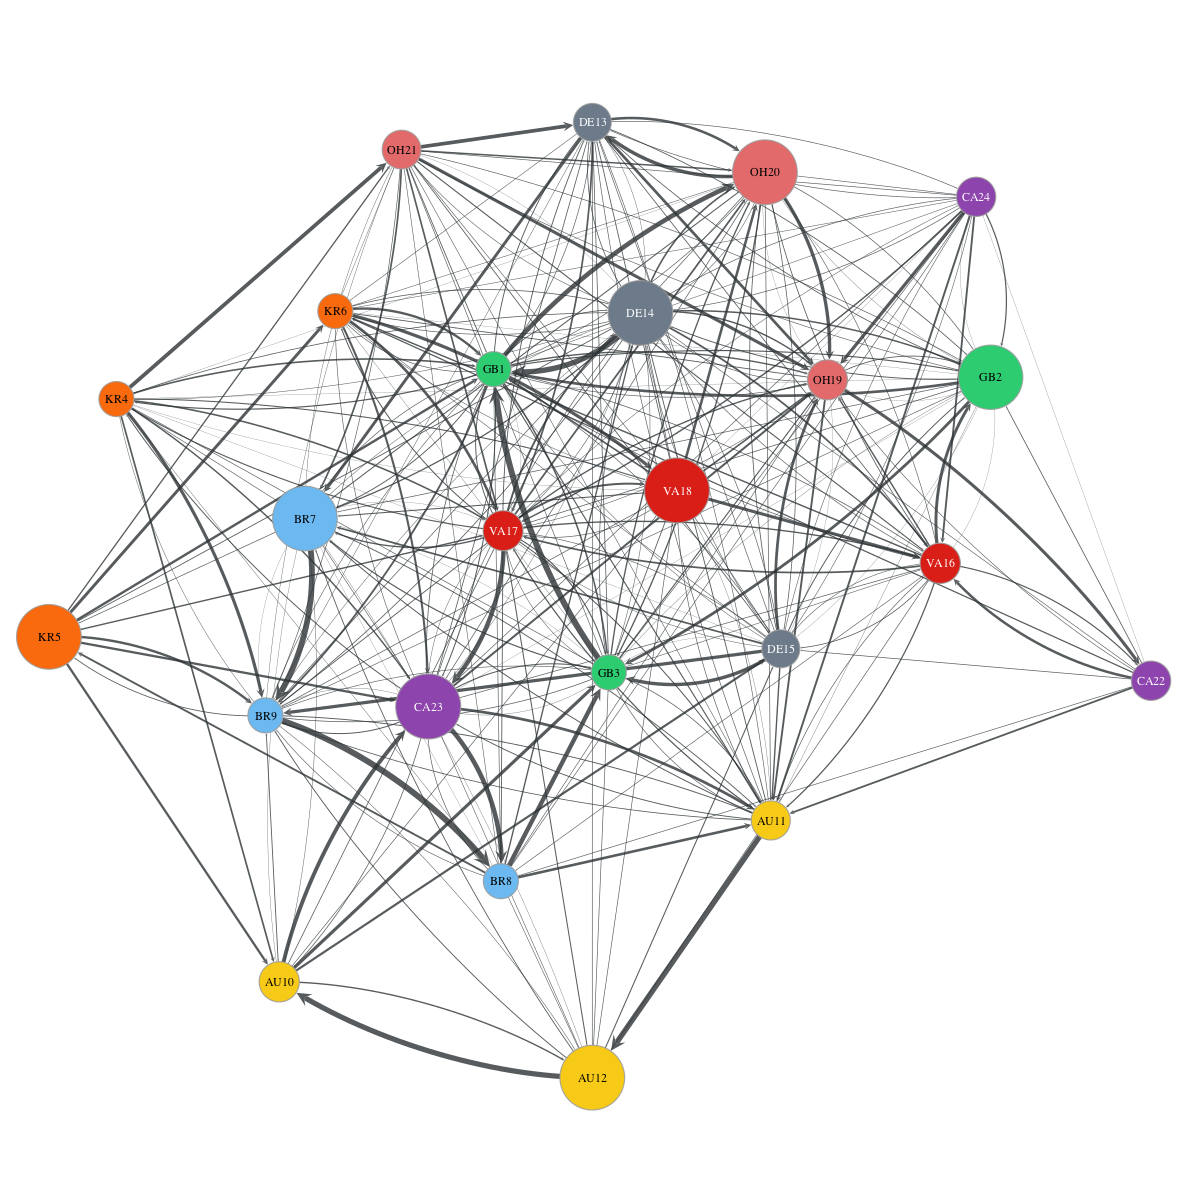

In [27]:
LOCATION_COLORS = {
    "Virginia": "#D91E18", 
    "Ohio": "#E26A6A", 
    "California": "#8E44AD", 
    "Sao Paulo": "#6BB9F0", 
    "London": "#2ECC71", 
    "Frankfurt": "#6C7A89", 
    "Seoul": "#F9690E", 
    "Sydney": "#F7CA18", 
}
LOCATION_GROUPS = sorted(list(LOCATION_COLORS.keys()))
LOCATION_CODES = {
    "Virginia": "VA", 
    "Ohio": "OH", 
    "California": "CA", 
    "Sao Paulo": "BR", 
    "London": "GB", 
    "Frankfurt": "DE", 
    "Seoul": "KR", 
    "Sydney": "AU", 
}

def filter_edges(h, pulls=0, pushes=0):
    # Create a view of the graph with only edges with syncs > 0 
    efilt = h.new_edge_property('bool')
    for edge in h.edges():
        efilt[edge] = (h.ep['pulls'][edge] > pulls or h.ep['pushes'][edge] > pushes)
    return gt.GraphView(h, efilt=efilt)


def mklabel(name, loc):
    code = LOCATION_CODES[loc]
    parts = name.split("-")
    return "{}{}".format(code, parts[-1])


def visualize_graph(G, layout='sfdp', filter=True, save=True):
    print(G.name)
    output = None
    if save:
        output = os.path.join("../figures", slugify(G.name) + ".pdf")
    
    # Convert the nx Graph to a gt Graph 
    g = nx2gt(G) 
    if filter:
        g = filter_edges(g)
    
    # Vertex Properties 
    vgroup = g.new_vertex_property('int32_t')
    vcolor = g.new_vertex_property('string')
    vlabel = g.new_vertex_property('string')
    for vertex in g.vertices():
        vcolor[vertex] = LOCATION_COLORS[g.vp['location'][vertex]]
        vgroup[vertex] = LOCATION_GROUPS.index(g.vp['location'][vertex])
        vlabel[vertex] = mklabel(g.vp['name'][vertex], g.vp['location'][vertex])
    vsize = gt.prop_to_size(g.vp['writes'], ma=65, mi=35)
    
    # Edge Properties 
    esize  = gt.prop_to_size(g.ep['versions'], mi=.01, ma=6)
    ecolor = gt.prop_to_size(g.ep['mean_pull_latency'], mi=1, ma=5, log=True)
    
    # Compute the layout and draw 
    if layout == 'fruchterman_reingold':
        pos = gt.fruchterman_reingold_layout(g, weight=esize, circular=True, grid=False)
    elif layout == 'sfdp':
        pos = gt.sfdp_layout(g, eweight=esize, groups=vgroup)
    else:
        raise ValueError("unknown layout '{}".format(layout))

    gt.graph_draw(
        g, pos=pos, output_size=(1200,1200), output=output, inline=True,
        vertex_size=vsize, vertex_fill_color=vcolor, vertex_text=vlabel, 
        vertex_halo=False, vertex_pen_width=1.2,
        edge_pen_width=esize,
    )
    
    
visualize_graph(extract_graphs()[2])

## Rewards DataFrame  

This section extracts a timeseries of rewards on a per-replica basis. 

In [63]:
def extract_rewards(path=DATA):
    for row in load_results(path):
        bandit = row["bandit"]
        history = bandit["history"]
        strategy = bandit["strategy"]
        epsilon = row["config"]["replicas"].get("epsilon")
        if epsilon:
            strategy += " ε={}".format(epsilon)
        values = np.array(list(map(float, history["rewards"])))
        series = pd.Series(values, name=row["name"] + " " + strategy)
        yield series, row['runid']

In [80]:
total_rewards = {} 
for series, rowid in extract_rewards():
    if rowid not in total_rewards:
        total_rewards[rowid] = series 
    else:
        total_rewards[rowid] += series 

In [84]:
cumulative_rewards = {
    rowid: s.cumsum()
    for rowid, s in total_rewards.items()
}

<IPython.core.display.Javascript object>


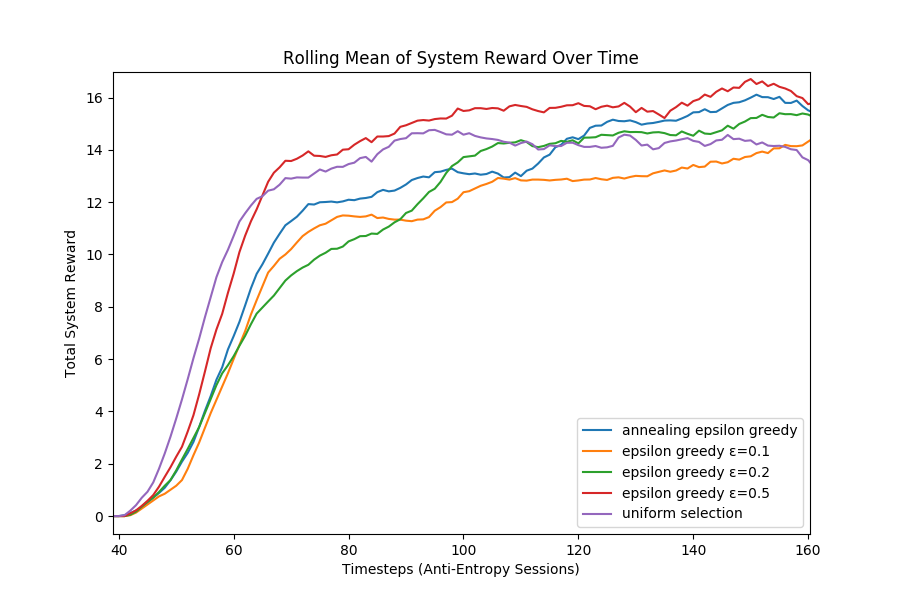

/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=15,center=False).mean()
  


Text(0.5,0,'Timesteps (Anti-Entropy Sessions)')

In [104]:
from pandas.plotting import autocorrelation_plot
df = pd.DataFrame({
    " ".join(s.name.split(" ")[1:]): s 
    for s in total_rewards.values()
})

fig,ax = plt.subplots(figsize=(9,6))
pd.rolling_mean(df, 15).plot(ax=ax)
ax.set_title("Rolling Mean of System Reward Over Time")
ax.set_ylabel("Total System Reward")
ax.set_xlabel("Timesteps (Anti-Entropy Sessions)")